# Hierarchical characterisation plots




In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import scipy as sp
import scipy.stats as spst
import scipy.interpolate as spint
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from IPython.utils import io
import progress

from experimentlauncher import ExperimentLauncher
from dataio import DataIO
import plots_experimental_data

import re
import inspect
import imp

import utils
import load_experimental_data
import highdimensionnetwork
import hierarchicalrandomnetwork

from plots_fitexperiment_papertheo import PlotsFitExperimentAllTPaperTheo
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2})

## Hierarchical network

In [3]:
arguments_dict = dict(
    action_to_do='launcher_do_simple_run',
    inference_method='sample',
    N=100,
    num_samples=50,
    label='thesis_hierarchical_coverage',
    output_directory='./Figures/thesis/hierarchical_coveragespace/',
    T=1,
    num_repetitions=5,
    renormalize_sigma=None,
    autoset_parameters=None,
    M=100,
    code_type='hierarchical',
    type_layer_one='feature',
    output_both_layers=None,
    ratio_hierarchical=0.3,
    normalise_weights=1,
    threshold=1.0,
    sigmax=0.3,
    sigmay=0.000001,
    sigma_output=0.0,
    selection_num_samples=1,
    selection_method='last',
    slice_width=0.07,
    burn_samples=100,
    enforce_min_distance=0.17,    
    specific_stimuli_random_centers=None,
    stimuli_generation='random',
    stimuli_generation_recall='random',
    experiment_data_dir=os.path.normpath(os.path.join(os.environ['WORKDIR_DROP'], '../../experimental_data')),
)
with io.capture_output(display=False, stdout=True) as captured:
    experiment_launcher = ExperimentLauncher(run=True, arguments_dict=arguments_dict)
    sampler = experiment_launcher.all_vars['sampler']
    network = sampler.random_network
    
sampler.fit_mixture_model()

{'K': 0.0,
 'aic': 306.43018285726788,
 'bic': 316.85086360122023,
 'kappa': 47.153947565735258,
 'mixt_nontargets': 0.0,
 'mixt_nontargets_sum': 0.0,
 'mixt_random': 0.65983024559309866,
 'mixt_target': 0.34016975440690123,
 'train_LL': -149.21509142863394}

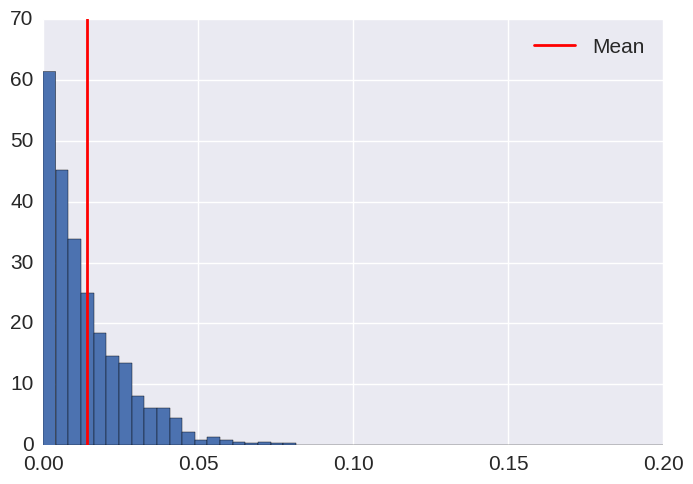

In [5]:
f, ax = plt.subplots()
ax.hist(network.A_sampling.flatten(), bins=np.linspace(0, 0.2, 50), normed=True)
ax.axvline(np.mean(network.A_sampling), color='r')
ax.legend(['Mean'])

# f.savefig(dataio.create_formatted_filename("hist_weights_{label}_{unique_id}.pdf"))

In [25]:
# ratio_space = np.linspace(0., 0.9, 50)
# num_repetitions = 1

# mem_fidelities = np.zeros((ratio_space.size, num_repetitions))
# precisions = np.zeros((ratio_space.size, num_repetitions))

# for ratio_i, ratio in progress.ProgressDisplay(enumerate(ratio_space), display=progress.SINGLE_LINE):
# #     print "Ratio hierarchical:", ratio
#     arguments_dict['ratio_hierarchical'] = ratio
    
#     for repet_i in xrange(num_repetitions):
#         with io.capture_output(display=False, stdout=True) as captured:
#             experiment_launcher = ExperimentLauncher(run=True, arguments_dict=arguments_dict)
#             sampler = experiment_launcher.all_vars['sampler']

#             mem_fidelities[ratio_i, repet_i] = sampler.fit_mixture_model()['kappa']
#             precisions[ratio_i, repet_i] = sampler.get_precision()


In [38]:
# plt.plot(ratio_space, mem_fidelities)

### 2D plot of M and ratio

In [6]:
def compute_spline_interpolation(df, interpolate_column, x_col='', y_col='', kx=3, ky=3, s=None):
    
    if "std_" + interpolate_column in df:
        w = 1./df["std_" + interpolate_column]
    else:
        w = None
        
    return spint.SmoothBivariateSpline(df[x_col], df[y_col], df[interpolate_column], w=w, kx=kx, ky=ky, s=s)

def pcolor_2d_interpolated(df, target_column, x_col='M', y_col='rc_scale', 
                           title='', vmin=None, vmax=None, cmap='RdBu_r'):
    x_int_space = np.sort(df[x_col].unique())
    y_int_space = np.sort(df[y_col].unique())

    spline_int = compute_spline_interpolation(df, target_column, 
                                              x_col=x_col, y_col=y_col)
    return utils.pcolor_2d_data(spline_int(x_int_space, y_int_space),
                                x=x_int_space, 
                                y=y_int_space, 
                                xlabel=x_col, 
                                xlabel_format="%d", 
                                ylabel=y_col, 
                                title=title,
                                ticks_interpolate=15,
                                vmin=vmin,
                                vmax=vmax,
                                log_scale=False, 
                                cmap=cmap
                               )

In [7]:
%cd /nfs/data3/lmatthey/visual_working_mem/fit_mixturemodels/

with io.capture_output(display=False, stdout=True) as captured:
    %run reloader_fit_mixturemodels_hierarchical_Mratio_grid_270617.py

/nfs/data3/lmatthey/visual_working_mem/fit_mixturemodels


In [8]:
# Extract data
num_repetitions = generator_module.num_repetitions
parameter_names_sorted = data_pbs.dataset_infos['parameters']
all_args_arr = np.array(data_pbs.loaded_data['args_list'])

In [28]:
pandas_columns_with_processing = [
    ('result_all_precisions', dict(name='precision', process=utils.process_precision)),
    ('result_em_fits', dict(name='emfit', process=utils.process_em_fits)),
]

df_all_fits = utils.construct_pandas_dataframe(data_pbs, pandas_columns_with_processing, num_repetitions)
df_all_fits.loc[:, ('M')] = df_all_fits.loc[:, ('M')].astype(int)

M_space = np.sort(df_all_fits['M'].unique())
ratio_hier_space = np.sort(df_all_fits['ratio_hierarchical'].unique())


In [63]:
targets_fidelity = [500, 1000, 2000]
clip_distance = 200

for target_fidelity in targets_fidelity:
    df_all_fits.loc[:, 'emfit_fidelity_distance_{}'.format(target_fidelity)] = np.clip(
        df_all_fits.emfit_fidelity - target_fidelity, -clip_distance, clip_distance)

In [64]:
df_all_fits.describe()

,precision,std_precision,precision_stddev,emfit_kappa,emfit_target,emfit_nontargets,emfit_random,emfit_LL,emfit_bic,emfit_fidelity,emfit_stddev,std_emfit_kappa,std_emfit_fidelity,std_emfit_stddev,M,ratio_hierarchical,emfit_fidelity_distance_500,emfit_fidelity_distance_1000,emfit_fidelity_distance_2000
count,7487.000000,7487.000000,7487.000000,7487.000000,7487.000000,7487.0,7.487000e+03,7487.000000,7487.000000,7487.000000,7487.000000,7487.000000,7487.000000,7487.000000,7487.000000,7487.000000,7487.000000,7487.000000,7487.000000
mean,3991.736356,694.635522,0.159008,4023.599779,0.978108,0.0,2.189188e-02,374.139820,-732.384688,4023.096779,0.063166,692.560805,692.561226,0.010732,206.283558,0.481181,52.520356,8.087647,-37.207009
std,6430.506159,1188.558411,0.337546,6427.886042,0.081547,0.0,8.154744e-02,234.703870,469.407741,6427.887887,0.095922,1279.552250,1279.551968,0.044882,111.197136,0.281932,184.138111,195.622026,194.267326
min,0.152124,0.003705,0.007181,0.317672,0.012694,0.0,3.219017e-12,-367.432741,-1465.443641,0.269925,0.005074,0.079706,0.079963,0.000004,10.000000,0.000100,-200.000000,-200.000000,-200.000000
25%,174.330541,31.075074,0.020677,215.768604,0.997903,0.0,5.468535e-11,240.236260,-1097.722500,215.267632,0.014374,32.115339,32.115604,0.001099,110.000000,0.237450,-200.000000,-200.000000,-200.000000
50%,1091.233759,197.426089,0.044743,1129.929015,1.000000,0.0,5.665825e-10,413.611516,-811.328080,1129.428831,0.029756,175.152505,175.152567,0.002513,205.000000,0.474800,200.000000,129.428831,-200.000000
75%,4826.630930,808.944271,0.123725,4840.689843,1.000000,0.0,2.096762e-03,556.808726,-464.577567,4840.189800,0.068157,788.653812,788.653814,0.006522,302.500000,0.727300,200.000000,200.000000,200.000000
max,38834.377506,11031.307570,3.669424,38834.877512,1.000000,0.0,9.873059e-01,740.669297,750.760434,38834.377506,1.924769,40027.138423,40027.148950,1.011548,395.000000,0.989900,200.000000,200.000000,200.000000


In [65]:
# Remove outliers
df_fits_filtered = utils.remove_outliers(df_all_fits, 5)

## Quantize parameters

In [66]:
# # First quantize Sigma_x and filter it out
# nQuantiles = 30
# parameters = ['sigmax']
# df_quantized, param_qbins, param_qbins_middle = df_add_quantize_parameters(df_fits_filtered, parameters, nQuantiles)
# df_fits_nosigmax = filter_quantized_param(df_quantized, {'sigmax': 0.3}, param_qbins).reset_index(drop=True)
# # Now quantize ratio_hierarchical
# nQuantiles = 50
# parameters = ['M', 'ratio_hierarchical']

# df_fits_nosigmax_quant, param_qbins, param_qbins_middle = df_add_quantize_parameters(
#     df_fits_nosigmax, parameters, nQuantiles)

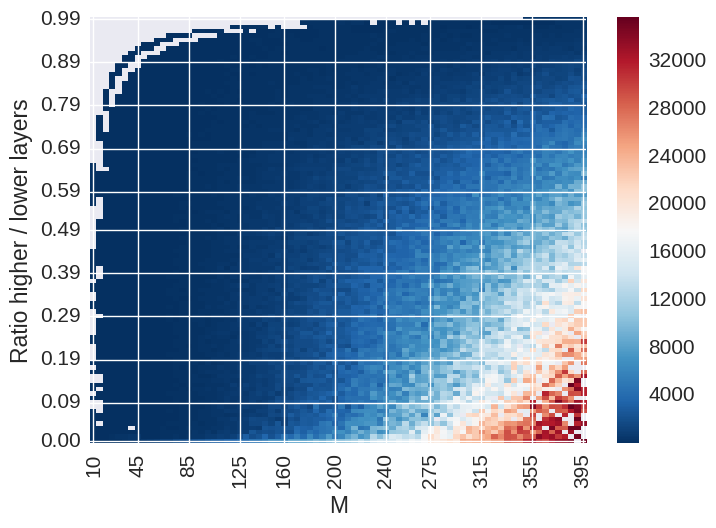

In [67]:
data_M_ratio = df_fits_filtered.pivot_table(index='M', 
                                            columns='ratio_hierarchical', 
                                            values='emfit_fidelity').as_matrix()

ax, _ = utils.pcolor_2d_data(data_M_ratio, x=M_space, y=ratio_hier_space, 
                             xlabel="M", ylabel="Ratio higher / lower layers", xlabel_format = "%d", 
                             ticks_interpolate=11, cmap='RdBu_r', log_scale=False)

In [68]:
# ax.get_figure().savefig(dataio.create_formatted_filename("hierarchical_2d_Mratio_{label}_{unique_id}.pdf"))

In [69]:
# Quantize parameters to smooth stuff up a bit

nQuantiles = 41
parameters = ['M', 'ratio_hierarchical']

df_fits_quants, param_qbins, param_qbins_middle = utils.df_add_quantize_parameters(
    df_fits_filtered, parameters, nQuantiles)
df_fits_q_avg = df_fits_quants.groupby(('M_qi', 'ratio_hierarchical_qi')).mean().reset_index()

In [70]:
# data_q_M_ratio = df_fits_q_avg.pivot_table(index='M_qi', 
#                                            columns='ratio_hierarchical_qi', 
#                                            values='emfit_fidelity'
#                                           ).as_matrix()

# ax, _ = utils.pcolor_2d_data(data_q_M_ratio, x=param_qbins_middle['M'], y=param_qbins_middle['ratio_hierarchical'], 
#                              xlabel="M", ylabel="Ratio higher / lower layers", xlabel_format = "%d", 
#                              ticks_interpolate=11, cmap='RdBu_r', log_scale=False)

In [71]:
cmap_div = sns.diverging_palette(h_neg=29, h_pos=265, s=80, l=85, sep=10, as_cmap=True, center='dark')

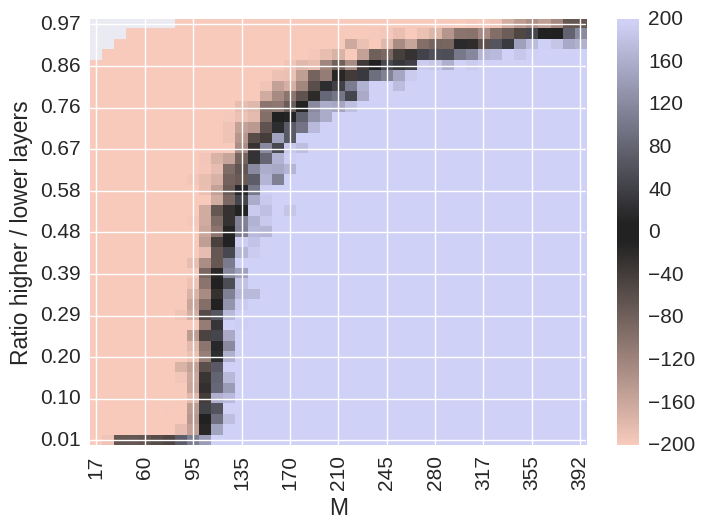

In [73]:
data_q_M_ratio = df_fits_q_avg.pivot_table(index='M_qi', 
                                           columns='ratio_hierarchical_qi', 
                                           values='emfit_fidelity_distance_500'
                                          ).as_matrix()

ax, _ = utils.pcolor_2d_data(data_q_M_ratio, x=param_qbins_middle['M'], y=param_qbins_middle['ratio_hierarchical'], 
                             xlabel="M", ylabel="Ratio higher / lower layers", xlabel_format = "%d", 
                             ticks_interpolate=11, cmap=cmap_div, log_scale=False)